Importing modules + training data

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing, linear_model, model_selection, metrics, neighbors, ensemble
import numpy as np

# your files might be in "Shared with me" instead of "My Drive", or you could just manually upload to the Colab and remove the "drive/My Drive/STAT441 Kaggle/" part entirely
df_ed_train = pd.read_csv("./module_Education_train_set.csv")
df_hh_train = pd.read_csv("./module_HouseholdInfo_train_set.csv")
y_train = pd.read_csv("./module_SubjectivePoverty_train_set.csv")

df_ed_test = pd.read_csv("./module_Education_test_set.csv")
df_hh_test = pd.read_csv("./module_HouseholdInfo_test_set.csv")

Combining DFs

In [71]:
#adding the 'psu_hh_idcode' column for future merging
df_ed_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_train.iterrows()]
df_ed_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_hh_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_train.iterrows()]
df_hh_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_ed_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_test.iterrows()]
df_ed_test.drop(['hh', 'idcode'], axis=1, inplace=True)

df_hh_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_test.iterrows()]
df_hh_test.drop(['hh', 'idcode'], axis=1, inplace=True)

# combining the subjective_poverty_n columns into a single column
y_train = y_train[y_train['psu_hh_idcode'].isin(df_ed_train['psu_hh_idcode'])]
sp_onehot = y_train.drop(columns=['psu_hh_idcode'])
y_train['subjective_poverty'] = pd.from_dummies(sp_onehot)
y_train.drop(columns=['subjective_poverty_' + str(i) for i in range(1,11)], inplace=True)

df_ed_train.set_index('psu_hh_idcode', inplace=True)
df_hh_train.set_index('psu_hh_idcode', inplace=True)
df_ed_test.set_index('psu_hh_idcode', inplace=True)
df_hh_test.set_index('psu_hh_idcode', inplace=True)

y_train.set_index('psu_hh_idcode', inplace=True)

#MAYBE REMOVE THIS PART:
# All other columns in the education test set are almost 99% NA
# Theoretically including all the rest of the columns should only give at most a score improvement of ~0.023
# since it only applies to 1% of the training data (and just giving every option a 0.1 chance is a log loss of 2.3)
df_ed_train = df_ed_train[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_train['set'] = 'train'
df_ed_test = df_ed_test[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_test['set'] = 'test'

# combining training and test sets
df_ed = pd.concat([df_ed_train, df_ed_test])
df_hh = pd.concat([df_hh_train, df_hh_test])

df = df_hh.join(df_ed, lsuffix="_hh", how='inner')


Filling in NAs

In [72]:
df['q07'].fillna(0) # q07 in education is NA => never went to school => 0 years of preschool

#Maybe remove
df['q15'].fillna(90)
df['q21'].fillna(90)

def highest_education(index):
  row = df_ed.loc[index]
  if row['q03'] == 2 or row['q06'] == 0:
    return 1 # no education
  elif row['q06'] == 1:
    return 2 # primary 4/5
  elif row['q06'] == 2 and row['q04'] == 1:
    return 3 # primary 7/8/9
  elif row['q04'] == 2 and row['q06'] < 3:
    return 4 # some secondary
  elif row['q06'] == 3 and row['q04'] == 2:
    return 5 # finished secondary
  elif row['q06'] < 4 and row['q04'] in [3,4,5]:
    return 6 # some vocational (pretty sure "Technicum" is  a type of vocational)
  elif row['q06'] in [4,5,6] and row['q04'] < 6:
    return 7 # finished vocational
  elif row['q06'] < 7 and row['q04'] >= 6:
    return 8 # some university
  elif row['q06'] in [7,8,9]:
    return 9 # finished university
  else:
    return 10 # Post university



for index, row in df.iterrows():
  if row['q11'] == 1:
    mother = '_'.join(index.split('_')[:-1] + [str(int(row['q12']))])
    if mother in df_ed.index:
        row['q13'] = highest_education(mother)
    elif mother in df_ed.index:
        row['q13'] = highest_education(mother)
    row['q14'] = 1
    if mother in df_hh.index:
        row['q16'] = df_hh.loc[mother]['q05y']

  if row['q17'] == 1:
    father = '_'.join(index.split('_')[:-1] + [str(int(row['q18']))])
    if father in df_ed.index:
        row['q19'] = highest_education(father)
    row['q20'] = 1
    if father in df_hh.index:
        row['q22'] = df_hh.loc[father]['q05y']

df.drop(columns=['q12', 'q18'], inplace=True)


Feature engineering

In [73]:
#df['highest_ed'] = [highest_education(ind) for ind, row in df.iterrows()]
#df.drop(columns=['q04', 'q05'], inplace=True)

# Replace Q05
df['years_primary'] = [row['q05'] if row['q04'] == 1 else 0 for i,row in df.iterrows()]
df['years_secondary'] = [row['q05'] if row['q04'] == 2 else 0 for i,row in df.iterrows()]
df['years_vocational'] = [row['q05'] if row['q04'] in [3,4,5] else 0 for i,row in df.iterrows()]
df['years_uni'] = [row['q05'] if row['q04'] in [6,7] else 0 for i,row in df.iterrows()]
df['years_postgrad'] = [row['q05'] if row['q04'] in [8,9,10,11] else 0 for i,row in df.iterrows()]
df.drop(columns=['q05'], inplace=True)
#df.drop(columns=['q05', 'Q13', 'Q22'], inplace=True)

# Combine postsecondary for q4
#df['q04'] = [min(row['q04'], 6.0) for i,row in df.iterrows()]
# ^ TRY WITHOUT THIS ERR(1)

# combine age (year and month) into single number
# Note: Maybe change this to categorical for logistic regression? Seems unlikely
#       to be linear
df['age'] = df['q05y'] + df['q05m'] / 12
df.drop(columns=['q05y', 'q05m'], inplace=True)
def age_group(age):
    if (age < 12):
        return 0
    elif (age < 18):
        return 1
    elif (age < 30):
        return 2
    elif (age < 40):
        return 3
    elif (age < 50):
        return 4
    elif (age < 60):
        return 5
    else:
        return 6
df['age_group'] = [age_group(age) for age in df['age']]
#df.drop(columns=['age'], inplace=True)

print(df['age_group'].value_counts())

# following commented out because we removed the q24 column

"""
# turn q24_ed (distance from school) into categorical
def distance_category(dist):
  if dist == 0:
    return 0
  if dist < 1:
    return 1
  if dist < 2:
    return 2
  if dist < 3:
    return 3
  if dist < 4:
    return 4
  if dist < 5:
    return 5
  if dist < 10:
    return 6
  if dist < 50:
    return 7
  if dist < 100:
    return 8
  return 9

df['dist_from_school'] = [distance_category(dist) for dist in df['Q24']]
df.drop(columns=['Q24'], inplace=True)
"""

age_group
2    4957
6    4038
5    3555
4    3548
1    2915
3    2786
0    1941
Name: count, dtype: int64


"\n# turn q24_ed (distance from school) into categorical\ndef distance_category(dist):\n  if dist == 0:\n    return 0\n  if dist < 1:\n    return 1\n  if dist < 2:\n    return 2\n  if dist < 3:\n    return 3\n  if dist < 4:\n    return 4\n  if dist < 5:\n    return 5\n  if dist < 10:\n    return 6\n  if dist < 50:\n    return 7\n  if dist < 100:\n    return 8\n  return 9\n\ndf['dist_from_school'] = [distance_category(dist) for dist in df['Q24']]\ndf.drop(columns=['Q24'], inplace=True)\n"

One hot encoding for categorical variables + cleanup

In [74]:
categorical = ['q01', 'q02', 'q06','Q11', 'Q17','q03_hh', 'q06_hh', 'q13', 'q19',
               'age_group', 'psu']#'highest_ed']

# following commented out because we removed most columns
"""categorical = ['q04', 'q06', 'Q10', 'Q11', 'Q12', 'Q16', 'Q17',
               'Q21', 'Q23', 'Q28', 'Q42', 'Q44', 'Q48', 'Q52',
               'Q53', 'Q63', 'Q66', 'q03_hh', 'q06_hh', 'q13', 'q19',
               'dist_from_school']
"""

# create onehot df and add it to the original df
for col in categorical:
    new_onehot = pd.get_dummies(df[col], prefix = col)
    df = pd.concat([df, new_onehot],axis=1)

# drop the original categorical
df.drop(columns=categorical, inplace=True)

# useless columns (q04_hh is date of birth, redundant with q05 which is age)
# hhid would be useful, but no observations in the train and test set share a hhid
df.drop(columns=['q04_hh', 'hhid'], inplace=True)

Normalization + train test split + filling in remaining NAs

In [85]:
# For real test set:
df_train = df.join(y_train, how='inner')
df_test = df[df['set'] == 'test']

In [86]:

#----------------------------------------------------------------------------------------------------------------------
# For development test set:
#df_final = df.join(y_train, how='inner')
#df_train,df_test = model_selection.train_test_split(df_final, train_size = 0.8)
#----------------------------------------------------------------------------------------------------------------------

same_cols = []

means = {}
stds = {}

# standardization
for col in df_train:
    if col not in ['psu_hh_idcode', 'subjective_poverty', 'set'] :
        if df_train[col].std() == 0 or df_test[col].std() == 0:
            print("all same", col)
            same_cols.append(col)
            continue
        means[col] = df_train[col].mean()
        stds[col] = df_train[col].std()
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_test[col] = (df_test[col] - means[col]) / stds[col]

# drop columns that are all the same (i.e. give no info) in train or test set
df_train.drop(columns=same_cols, inplace=True)
df_test.drop(columns=same_cols, inplace=True)

# fill remaining NAs with 0 (i.e. mean)
# maybe change this part to be smarter
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_73843/2657691468.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = (df_test[col] - means[col]) / stds[col]


all same q10
all same q06_8.0
all same Q11_5.0
all same Q11_7.0
all same Q11_9.0
all same Q11_11.0
all same Q17_5.0
all same Q17_6.0
all same Q17_9.0
all same Q17_11.0
all same q03_hh_5
all same q03_hh_6
all same q03_hh_8
all same q03_hh_10
all same q03_hh_11
all same q03_hh_12
all same q03_hh_13
all same q03_hh_14
all same q06_hh_3.0
all same age_group_0
all same psu_4
all same psu_6
all same psu_8
all same psu_11
all same psu_14
all same psu_22
all same psu_23
all same psu_27
all same psu_34
all same psu_35
all same psu_37
all same psu_39
all same psu_40
all same psu_54
all same psu_55
all same psu_56
all same psu_58
all same psu_61
all same psu_67
all same psu_69
all same psu_74
all same psu_79
all same psu_82
all same psu_86
all same psu_94
all same psu_98
all same psu_111
all same psu_114
all same psu_126
all same psu_130
all same psu_132
all same psu_137
all same psu_138
all same psu_139
all same psu_142
all same psu_148
all same psu_150
all same psu_154
all same psu_155
all same

/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_73843/2657691468.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=same_cols, inplace=True)
/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_73843/2657691468.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.fillna(0, inplace=True)


Fit + eval for logistic regression, KNN, random forest, boosting

In [87]:
import numpy as np
import scipy.ndimage

def smooth(p):
    # Ensure the probabilities sum to 1
    p = p / np.sum(p)

    # Identify the index and value of the maximum probability
    max_idx = np.argmax(p)
    p_max = p[max_idx]

    # Set K as (N / 2) squared, where N is the length of p
    N = len(p)
    K = (N / 2) ** 2

    # Compute sigma_squared based on the maximum probability
    sigma_squared = K * (1 - p_max)

    # If sigma_squared is zero, no smoothing is needed
    if sigma_squared == 0:
        return p  # Return the original probabilities

    # Compute Gaussian weights centered at max_idx
    indices = np.arange(N)
    gaussian_weights = np.exp(-((indices - max_idx) ** 2) / (2 * sigma_squared))

    # Apply the Gaussian weights to the probabilities
    p_new = p * gaussian_weights

    # Normalize the new probabilities so they sum to 1
    p_new /= np.sum(p_new)

    return p_new

for idx, item in df_train.iterrows():
  if item["set"] == "test":
    print("misrepresented")

X = df_train.drop(columns=["subjective_poverty", "set"])
y = df_train["subjective_poverty"]


#development test set
#X_test = df_test.drop(columns=["subjective_poverty", "set"])
#y_test = df_test["subjective_poverty"]

# actual test set
X_test = df_test.drop(columns=["set"])

In [77]:
# First fit the model
lr = linear_model.LogisticRegressionCV(
    cv=5,
    penalty='l2',
    scoring='neg_log_loss',
    max_iter=1000,
    n_jobs=-1,
    random_state=0
)
lr.fit(X, y)

# Get the mean scores and standard errors
mean_scores = -np.mean(lr.scores_[list(lr.scores_.keys())[0]], axis=0)  # Negative because we used neg_log_loss
std_scores = np.std(lr.scores_[list(lr.scores_.keys())[0]], axis=0)

# Find the minimum score and its index
min_score_idx = np.argmin(mean_scores)
min_score = mean_scores[min_score_idx]

# Find the largest C value whose score is within one std err of the minimum
threshold = min_score + std_scores[min_score_idx]
valid_indices = np.where(mean_scores <= threshold)[0]
one_se_idx = valid_indices[0]  # Take the largest C value (first index due to C being in descending order)
optimal_c = lr.C_[one_se_idx]

# Refit with the one-SE C value
lr_final = linear_model.LogisticRegression(
    C=optimal_c,
    penalty='l2',
    max_iter=1000,
    random_state=0
)

probs_lr = lr_final.fit(X,y).predict_proba(X_test)
probs_lr_smooth = [smooth(i) for i in probs_lr]


#development test set
#print(metrics.log_loss(y_test, probs_lr, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_lr_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

In [78]:
#development test set
print(metrics.log_loss(y_test, probs_lr, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
print(metrics.log_loss(y_test, probs_lr_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

1.8308980572879394
1.8092113196934156


Optimal k: 261
Log loss (unsmoothed): 1.9469156200614113
Log loss (smoothed): 1.9398211986223777


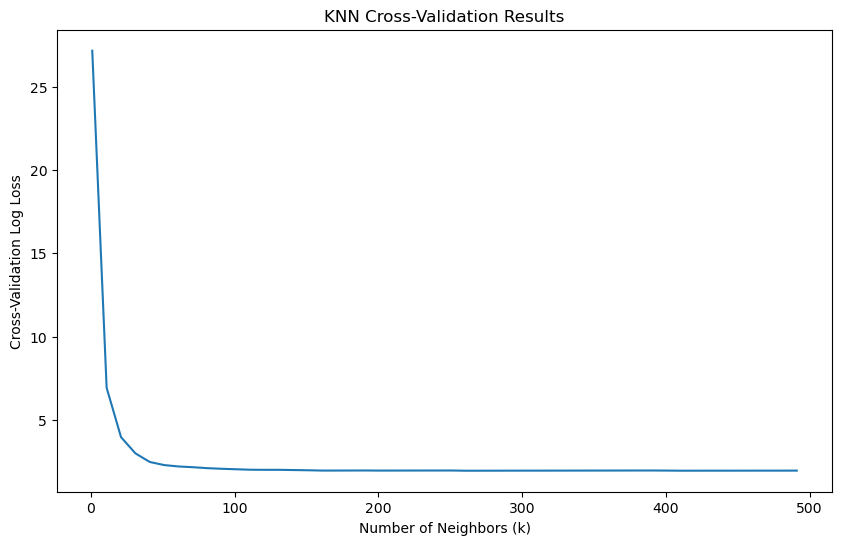

In [79]:
# Find optimal k using cross-validation
k_range = range(1, 501, 10)  # Test k values from 1 to 500 in steps of 10
cv_scores = []

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = model_selection.cross_val_score(knn, X, y, cv=5, scoring='neg_log_loss')
    cv_scores.append(-scores.mean())  # Negative because we want to minimize log loss

# Find the optimal k
optimal_k = k_range[np.argmin(cv_scores)]

# Train final model with optimal k
knn = neighbors.KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
probs_knn = knn.fit(X,y).predict_proba(X_test)

probs_knn_smooth = [smooth(i) for i in probs_knn]

# Print results
print(f"Optimal k: {optimal_k}")
print(f"Log loss (unsmoothed): {metrics.log_loss(y_test, probs_knn)}")
print(f"Log loss (smoothed): {metrics.log_loss(y_test, probs_knn_smooth)}")

# Optionally plot CV results
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Log Loss')
plt.title('KNN Cross-Validation Results')
plt.show()

In [80]:
print(metrics.log_loss(y_test, probs_knn, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
print(metrics.log_loss(y_test, probs_knn_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

1.9469156200614113
1.9398211986223777


In [81]:
rf = ensemble.RandomForestClassifier(random_state=0, criterion="log_loss")
probs_rf = rf.fit(X,y).predict_proba(X_test)
probs_rf_smooth = [smooth(i) for i in probs_rf]
print(metrics.log_loss(y_test, probs_rf, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
print(metrics.log_loss(y_test, probs_rf_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

2.7662500312987763
2.788031138982277


In [82]:
gb = ensemble.GradientBoostingClassifier(random_state=0)
probs_gb = gb.fit(X,y).predict_proba(X_test)
probs_gb_smooth = [smooth(i) for i in probs_gb]

# development test set
#print(metrics.log_loss(y_test, probs_gb, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_gb_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

In [83]:
# development test set
print(metrics.log_loss(y_test, probs_gb, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
print(metrics.log_loss(y_test, probs_gb_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

2.0037628520608983
2.010723522194802


In [284]:
# Really simple one
overall_probs = y_train.value_counts() / sum(y_train.value_counts())
y_pred = pd.DataFrame(index=X_test.index, columns = ['subjective_poverty_' + str(i) for i in range(1,11)])
for i in range(1,11):
    y_pred['subjective_poverty_' + str(i)] = overall_probs['subjective_poverty_' + str(i)]
#print(metrics.log_loss(y_test, y_pred, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

In [88]:
stack = ensemble.StackingClassifier([('logistic CV', lr_final), ('KNN', knn), ("Gradient boosting",gb)])
stack_fit = stack.fit(X,y)
probs_stack = stack_fit.predict_proba(X_test)
probs_stack_smooth = [smooth(i) for i in probs_gb]

# development test set
#print(metrics.log_loss(y_test, probs_stack, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_stack_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

#real test set
out_df = pd.DataFrame(index=df_test.index, columns = ['subjective_poverty_' + str(i) for i in range(1,11)], data=probs_stack)

print(len(out_df))
out_df.to_csv("probs.csv")

1334


In [286]:
things = {i:stack_fit.predict_proba(X_test.loc[[i]]) for i,row in X_test.iterrows()}


In [287]:
things2 = {i:things[i][0] for i in things}

new_df = pd.DataFrame.from_dict(things2, orient='index', columns = ['subjective_poverty_' + str(i) for i in range(1,11)])

m = 0
for i in new_df.index:
    m = max(m, sum(abs(new_df.loc[i] - out_df.loc[i])))
print(m)

8.488665716524513e-12


In [298]:
#adding the 'psu_hh_idcode' column for future merging
df_ed_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_train.iterrows()]
df_ed_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_hh_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_train.iterrows()]
df_hh_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_ed_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_test.iterrows()]
df_ed_test.drop(['hh', 'idcode'], axis=1, inplace=True)

df_hh_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_test.iterrows()]
df_hh_test.drop(['hh', 'idcode'], axis=1, inplace=True)

# combining the subjective_poverty_n columns into a single column
y_train = y_train[y_train['psu_hh_idcode'].isin(df_ed_train['psu_hh_idcode'])]
sp_onehot = y_train.drop(columns=['psu_hh_idcode'])
y_train['subjective_poverty'] = pd.from_dummies(sp_onehot)
y_train.drop(columns=['subjective_poverty_' + str(i) for i in range(1,11)], inplace=True)

df_ed_train.set_index('psu_hh_idcode', inplace=True)
df_hh_train.set_index('psu_hh_idcode', inplace=True)
df_ed_test.set_index('psu_hh_idcode', inplace=True)
df_hh_test.set_index('psu_hh_idcode', inplace=True)

y_train.set_index('psu_hh_idcode', inplace=True)

#MAYBE REMOVE THIS PART:
# All other columns in the education test set are almost 99% NA
# Theoretically including all the rest of the columns should only give at most a score improvement of ~0.023
# since it only applies to 1% of the training data (and just giving every option a 0.1 chance is a log loss of 2.3)
df_ed_train = df_ed_train[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_train['set'] = 'train'
df_ed_test = df_ed_test[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_test['set'] = 'test'

# combining training and test sets
df_ed = pd.concat([df_ed_train, df_ed_test])
df_hh = pd.concat([df_hh_train, df_hh_test])

df = df_hh.join(df_ed, lsuffix="_hh", how='inner')
df = df.join(y_train,how='inner')
df

<ipython-input-298-786514d9940e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['subjective_poverty'] = pd.from_dummies(sp_onehot)
<ipython-input-298-786514d9940e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.drop(columns=['subjective_poverty_' + str(i) for i in range(1,11)], inplace=True)
<ipython-input-298-786514d9940e>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,psu,hhid,q02_hh,q03_hh,q04_hh,q05y,q05m,q06_hh,q07_hh,q08,...,q06,q07,Q08,Q11,Q14,Q17,Q18,Q19,set,subjective_poverty
psu_hh_idcode,,,,,,,,,,,,,,,,,,,,,
1_2_1,1,102,1,1,19600711,52,1,1.0,1.0,2.0,...,2.0,1.0,2.0,13.0,2.0,13.0,14.0,2.0,train,subjective_poverty_2
1_3_1,1,103,1,1,19540203,58,7,1.0,1.0,2.0,...,9.0,1.0,2.0,13.0,2.0,13.0,22.0,2.0,train,subjective_poverty_4
1_5_1,1,105,1,1,19580322,54,5,1.0,1.0,2.0,...,1.0,0.0,2.0,2.0,2.0,2.0,10.0,2.0,train,subjective_poverty_6
1_11_1,1,111,1,1,19680126,44,7,1.0,1.0,2.0,...,3.0,1.0,2.0,13.0,2.0,13.0,18.0,2.0,train,subjective_poverty_6
1_12_1,1,112,2,1,19580511,54,3,4.0,NaN,NaN,...,3.0,1.0,2.0,13.0,2.0,13.0,18.0,2.0,train,subjective_poverty_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834_5_1,834,83405,1,1,19520118,60,7,1.0,2.0,NaN,...,2.0,1.0,2.0,4.0,2.0,4.0,14.0,2.0,train,subjective_poverty_5
834_6_1,834,83406,1,1,19430320,69,5,1.0,1.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,13.0,2.0,train,subjective_poverty_5
834_7_1,834,83407,1,1,19700423,42,4,5.0,NaN,NaN,...,9.0,2.0,2.0,4.0,2.0,4.0,22.0,2.0,train,subjective_poverty_5
